## Import Packages

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import argparse
import datetime
import math

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# The above could be sent to an independent module
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

import statsmodels.tsa.stattools as smts
import statsmodels.api as sm

import datetime as dt

## Read data

In [2]:
import glob
import os

nyse_csv_paths = []
nasdaq_csv_paths = []

# get file names of all csv files with nyse stock prices 
nyse_csv_paths = sorted(glob.glob("../ib-data/nyse-daily/*.csv"))
# nasdaq_csv_paths = sorted(glob.glob("../ib-data/nyse/*.csv"))
csv_paths = nyse_csv_paths + nasdaq_csv_paths

N_STOCKS = len(nyse_csv_paths)

In [3]:
data = {}
MIN_SIZE = 252*4
N_STOCKS_TAKEN = 0

for path in csv_paths:
    # get the file names
    filename = os.path.basename(path)
    filename_without_ext = os.path.splitext(filename)[0]
    
    # read the csv file as dataframe
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    
    # if price history is long enough, we take it
    if len(df) >= MIN_SIZE:
        data[filename_without_ext] = df 
        N_STOCKS_TAKEN += 1

In [4]:
print("N_STOCKS = " + str(N_STOCKS))
print("N_STOCKS_TAKEN = " + str(N_STOCKS_TAKEN))

N_STOCKS = 170
N_STOCKS_TAKEN = 116


## Ensure all prices have same start date

In [5]:
# get max starting date
MAX_DATE = pd.Timestamp.min

for key in data.keys():
    # reset index 
    data[key] = data[key].reset_index(drop=True)
    
    # max
    MAX_DATE = max(MAX_DATE, data[key]['date'][0])
    
# take subset of all dataframes
for key in data.keys():
    data[key] = data[key][data[key]['date'] >= MAX_DATE]
    
    # reset index 
    data[key] = data[key].reset_index(drop=True)

## Aggregate prices

In [6]:
from pair_selector import *

In [7]:
# aggregate all close prices
close_price_df = pd.DataFrame()

for key in data.keys():
    close_price_df[key] = data[key]['close']

### Verify

In [8]:
# check if there are null values
close_price_df.isnull().values.any()

False

## Get K best pairs

Assuming we take the top 1% pairs ... 

In [9]:
N = len(data.keys())
print(int(N*(N-1)/2), 'pairs')

K = int(0.01 * N * (N-1) / 2)
print(K)

6670 pairs
66


In [21]:
TRAIN_PERIOD = 60

good_pairs = select_pairs_for_all_combin(train_df=close_price_df[0:TRAIN_PERIOD], test_df=None,
        config={'n': K, 'score_function': distance_score, 'series_transform': distance_transform}, plot=False)

good_pairs

{'n': 66, 'score_function': <function distance_score at 0x000001C6800EB2F0>, 'series_transform': <function distance_transform at 0x000001C6800EB400>}
True


[('FDS', 'NOW'),
 ('AER', 'MAN'),
 ('AER', 'NSP'),
 ('AER', 'FDS'),
 ('NSP', 'STM'),
 ('AER', 'ELLI'),
 ('AL', 'ASGN'),
 ('AL', 'FDS'),
 ('AER', 'ASGN'),
 ('AL', 'NOW'),
 ('AER', 'AL'),
 ('ASGN', 'FDS'),
 ('HUBS', 'LXFT'),
 ('ELLI', 'LXFT'),
 ('ELLI', 'NSP'),
 ('ELLI', 'PANW'),
 ('ASGN', 'WIT'),
 ('LXFT', 'SQNS'),
 ('ASGN', 'STM'),
 ('EPAM', 'LXFT'),
 ('ELLI', 'FDS'),
 ('ELLI', 'STM'),
 ('AER', 'LXFT'),
 ('AER', 'IPG'),
 ('FDS', 'PAYC'),
 ('AER', 'RHI'),
 ('FDS', 'RHI'),
 ('AER', 'STM'),
 ('STM', 'WIT'),
 ('ASGN', 'ELLI'),
 ('AL', 'MAN'),
 ('FDS', 'GWRE'),
 ('AL', 'RHI'),
 ('HUBS', 'SQNS'),
 ('LXFT', 'MAN'),
 ('AL', 'WIT'),
 ('ASGN', 'NSP'),
 ('JNPR', 'NOW'),
 ('HUBS', 'IPG'),
 ('ELLI', 'HUBS'),
 ('ELLI', 'IPG'),
 ('ASGN', 'RHI'),
 ('LXFT', 'PANW'),
 ('AMN', 'AYR'),
 ('GLOB', 'KAI'),
 ('FDS', 'IPG'),
 ('LXFT', 'TWTR'),
 ('FDS', 'MAN'),
 ('AER', 'TWTR'),
 ('GWRE', 'RHI'),
 ('IPG', 'LXFT'),
 ('FDS', 'WIT'),
 ('ASGN', 'MAN'),
 ('ELLI', 'MODN'),
 ('NSP', 'WIT'),
 ('LXFT', 'MODN'),
 ('EPAM'

## Strategy

In [22]:
class SinglePair(bt.Strategy):
    params = dict (
        period=84,
        upper_limit = 2,
        lower_limit = -2, 
        loss_limit = -0.015,
    )

    def log(self, txt, dt=None):        
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
#                 self.log(buytxt, order.executed.dt)
                self.incur_commission(order.executed.price, order.executed.size)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
#                 self.log(selltxt, order.executed.dt)
                self.incur_commission(order.executed.price, order.executed.size)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
#             self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        self.orderid = None
        
        # Strategy params
        self.period = self.p.period
        self.upper_limit = self.p.upper_limit
        self.lower_limit = self.p.lower_limit
        self.up_medium = 0.5
        self.low_medium = -0.5
        self.exposure = 200000
            
        # signals
        self.zscore = None
        self.adf_pvalue = None
        self.intercept = None
        self.slope = None
        self.resid_mean = None
        self.resid_std = None
        self.spread = None
        
        # temporary variables to keep track of trades
        self.status = 0
        self.qty0 = 0
        self.qty1 = 0
        self.initial_price_data0 = None
        self.initial_price_data1 = None
        self.initial_cash = None
        self.initial_long_pv = None
        self.initial_short_pv = None
        

    def next(self):
        if min(len(self.data0), len(self.data1)) < self.period:
            return
        
        if self.orderid:
            return  # if an order is active, no new orders are allowed
        
        ##################################################################################################
        # COMPUTE UPPER AND LOWER LIMITS                                                                 #
        ##################################################################################################
        Y = pd.Series(self.data0.get(size=self.period)[0:-1])
        X = pd.Series(self.data1.get(size=self.period)[0:-1])
        
        self.spread = (self.data0[0] - self.data1[0])
        
        if self.status == 0:
            self.spread_mean = (Y - X).mean()
            self.spread_std = (Y - X).std()

            self.upper_limit = self.spread_mean + 2 * self.spread_std
            self.lower_limit = self.spread_mean - 2 * self.spread_std
            self.up_medium = self.spread_mean + 0.5 * self.spread_std
            self.low_medium = self.spread_mean - 0.5 * self.spread_std
    
        ##################################################################################################
        # STRATEGY LOGIC                                                                                 #
        ##################################################################################################
        if self.status == 0:
            # "NO position" status
            
            if self.spread > self.upper_limit:
                self.short_spread()
            elif self.spread < self.lower_limit:
                self.long_spread()
     
        elif self.status == 1:
            # "SHORT the spread" status
            # short data0, long data1
            
            if self.spread < self.lower_limit:
                self.long_spread()
                
            elif self.spread < self.up_medium:
                self.exit_spread()
            
            else:
                long_pv = self.long_portfolio_value(self.data1.close, self.qty1)
                short_pv = self.short_portfolio_value(self.initial_price_data0, self.data0.close, self.qty0)
                net_gain_long = long_pv - self.initial_long_pv
                net_gain_short = short_pv - self.initial_short_pv

                return_of_current_trade = (net_gain_long + net_gain_short) / self.initial_cash

                # if losing too much money, exit
                if return_of_current_trade < self.p.loss_limit or short_pv <= 0:
                    self.exit_spread()
        
        elif self.status == 2:
            # "LONG the spread" status
            # short data1, long data0
            
            if self.spread > self.upper_limit:
                self.short_spread()
                
            elif self.spread > self.low_medium:
                self.exit_spread()
            
            else:
                long_pv = self.long_portfolio_value(self.data0.close, self.qty0)
                short_pv = self.short_portfolio_value(self.initial_price_data1, self.data0.close, self.qty1)
                net_gain_long = long_pv - self.initial_long_pv
                net_gain_short = short_pv - self.initial_short_pv

                return_of_current_trade = (net_gain_long + net_gain_short) / self.initial_cash

                # if losing too much money, exit
                if return_of_current_trade < self.p.loss_limit or short_pv <= 0:
                    self.exit_spread()
            
    
    def long_portfolio_value(self, price, qty):
        return price * qty
        
    def short_portfolio_value(self, price_initial, price_final, qty):
        return qty * (1.5 * price_initial - price_final)
    
    def short_spread(self):
        x = int((self.exposure / 3.0) / (self.data0.close))  
        y = int((2 * self.exposure / 3.0) / (self.data1.close))  

        # Placing the order
        self.sell(data=self.data0, size=(x + self.qty0))  # Place an order for buying y + qty2 shares
        self.buy(data=self.data1, size=(y + self.qty1))  # Place an order for selling x + qty1 shares

        # Updating the counters with new value
        self.qty0 = x  
        self.qty1 = y  
        
        # update flags
        self.status = 1
        
        # keep track of trade variables
        self.initial_cash = self.qty1 * self.data1.close + 0.5 * self.qty0 * self.data0.close
        self.initial_long_pv = self.long_portfolio_value(self.qty1, self.data1.close)
        self.initial_short_pv = 0.5 * self.data0.close * self.qty0
        self.initial_price_data0, self.initial_price_data1 = self.data0.close, self.data1.close
    
    def long_spread(self):
        # Calculating the number of shares for each stock
        x = int((2 * self.exposure / 3.0) / (self.data0.close)) 
        y = int((self.exposure / 3.0) / (self.data1.close)) 

        # Place the order
        self.buy(data=self.data0, size=(x + self.qty0))  # Place an order for buying x + qty1 shares
        self.sell(data=self.data1, size=(y + self.qty1))  # Place an order for selling y + qty2 shares

        # Updating the counters with new value
        self.qty0 = x 
        self.qty1 = y 
        
        # update flags
        self.status = 2  
        
        # keep track of trade variables
        self.initial_cash = self.qty0 * self.data0.close + 0.5 * self.qty1 * self.data1.close
        self.initial_long_pv = self.long_portfolio_value(self.qty0, self.data0.close)
        self.initial_short_pv = 0.5 * self.data1.close * self.qty1
        self.initial_price_data0, self.initial_price_data1 = self.data0.close, self.data1.close
    
    def exit_spread(self):
        # Exit position
        self.close(self.data0)
        self.close(self.data1)
        
        # update counters
        self.qty0 = 0
        self.qty1 = 0
        
        # update flags
        self.status = 0
        self.initial_cash = None
        self.initial_long_pv, self.initial_short_pv = None, None
        self.initial_price_data0, self.initial_price_data1 = None, None
        
    def incur_commission(self, price, qty):
        qty = abs(qty)
        commission = min(max(1, 0.005*qty), 0.01*price*qty)
        self.broker.add_cash(-1*commission)
    
    def stop(self):
        print("-", end="")
#         print('==================================================')
#         print('Starting Value: %.2f' % self.broker.startingcash)
#         print('Ending   Value: %.2f' % self.broker.getvalue())
#         print('Number of timeouts: %.2f' % self.n_timeouts)
#         print('==================================================')

- This is a class for backtesting (dist method) on a single pair
- look at notebook 4b to see how to initialize a cerebro object, pass 2 data feeds in and run backtest

## Backtest on all pairs

In [23]:
class PandasData(bt.feed.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        ('datetime', 0),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

## Bulk test

In [24]:
import uuid
import itertools

In [33]:
# global param
TEST_PERIOD = 252*2

# strategy params
lookback_values = [10, 15, 20, 25, 30]
upper_limit = [2, 3, 4]
loss_limit = [-0.01, -0.02, -0.03, -0.05]

# combinations of parameters
param_combinations = list(itertools.product(lookback_values, upper_limit, loss_limit))

# list to store MACRO results
macro_results = []

for params in param_combinations:
    # set params
    print("Backtesting all pairs using parameters " + str(params))
    # list to store MICRO results
    results = []

    for pair in good_pairs:
        # get names of both stock
        stk0, stk1 = pair

        # get data of both stock
        stk0_df, stk1_df = data[stk0], data[stk1]
        stk0_df_test, stk1_df_test = stk0_df[TRAIN_PERIOD:TRAIN_PERIOD + TEST_PERIOD], stk1_df[TRAIN_PERIOD:TRAIN_PERIOD + TEST_PERIOD]

        # Create a cerebro
        cerebro = bt.Cerebro()

        # Create data feeds
        data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
        data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

        # add data feeds to cerebro
        cerebro.adddata(data0)
        cerebro.adddata(data1)

        # Add the strategy
        cerebro.addstrategy(SinglePair, 
                            period=params[0], 
                            upper_limit=params[1], 
                            lower_limit=-1*params[1], 
                            loss_limit=params[2])

        # Add Sharpe Ratio
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcash(1000000)

        # And run it
        strat = cerebro.run()

        # get MICRO metrics
        sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
        startcash = cerebro.getbroker().startingcash
        endcash = cerebro.getbroker().getvalue()
        profit = (endcash - startcash) / startcash
        
        results.append((stk0 + "-" + stk1, sharperatio, profit))
    
    # convert to dataframe
    results_df = pd.DataFrame(results)
    results_df.columns = ['pair', 'sharpe_ratio', 'overall_return']
    
    # save as csv
    uuid_str = str(uuid.uuid4())
    path = "../backtest-results/distance/nasdaq-tech-daily-shortperiod/" + str(uuid_str) + ".csv" 
    results_df.to_csv(path_or_buf=path, index=False)
    
    # calculate MACRO attributes
    avg_sharpe_ratio = results_df['sharpe_ratio'].mean()
    avg_overall_return = results_df['overall_return'].mean()
    
    macro_results.append((params[0], 
                          params[1], 
                          params[2], 
                          avg_sharpe_ratio, 
                          avg_overall_return, 
                          uuid_str
                         ))
    
    # nextline
    print("")

macro_results_df = pd.DataFrame(macro_results)
macro_results_df.columns = ['lookback', 
                            'exit_threshold_size', 
                            'loss_limit', 
                            'avg_sharpe_ratio', 
                            'avg_overall_return', 
                            'uuid']
macro_results_df.to_csv('../backtest-results/distance/nasdaq-tech-daily-shortperiod/summary.csv', index=False)

Backtesting all pairs using parameters (10, 2, -0.01)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 2, -0.02)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 2, -0.03)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 2, -0.05)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 3, -0.01)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 3, -0.02)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 3, -0.03)
------------------------------------------------------------------
Backtesting all pairs using parameters (10, 3, -0.05)
------------------------------------------------------------------
Backtesting all pairs using para

In [34]:
macro_results_df

,lookback,exit_threshold_size,loss_limit,avg_sharpe_ratio,avg_overall_return,uuid
0,10,2,-0.01,-0.286182,0.021450,b2f56b99-382e-4e1a-a33b-09805c7ed393
1,10,2,-0.02,-0.526554,0.028247,1087a1ec-4618-4f1d-bdd2-a537dc08cc1a
2,10,2,-0.03,-0.496166,0.024582,57f0c0cb-1c99-4d50-ba90-75ad7e76fa98
3,10,2,-0.05,-0.457319,0.027515,15e24778-0709-4c1c-bb2e-ffe5dd787a60
4,10,3,-0.01,-0.286182,0.021450,b91f47c7-cf84-491b-ac6c-a921f98bc977
5,10,3,-0.02,-0.526554,0.028247,ed355803-ebc7-4944-9cd2-1e93bde041a4
6,10,3,-0.03,-0.496166,0.024582,e0298b58-4bb5-4d23-b182-d38f7bb1bb91
7,10,3,-0.05,-0.457319,0.027515,0606f7f7-920a-4c0a-9e1d-a56a6fb06d54
8,10,4,-0.01,-0.286182,0.021450,7862f3d1-69b0-4040-8ab6-22a008534d52
9,10,4,-0.02,-0.526554,0.028247,58c12bb0-8b31-4007-9d2a-2c5936d70d06


In [41]:
macro_results_df[macro_results_df['avg_overall_return'] == max(macro_results_df['avg_overall_return'])]

,lookback,exit_threshold_size,loss_limit,avg_sharpe_ratio,avg_overall_return,uuid
36,25,2,-0.01,-0.277145,0.036002,d1ec66e8-8998-4847-9f94-a07c400d7e80
40,25,3,-0.01,-0.277145,0.036002,6b88fbbc-e972-45b1-83a6-ef1a71ca1b28
44,25,4,-0.01,-0.277145,0.036002,0f35eaba-86db-47ce-984f-b001df93c233


In [44]:
df = pd.read_csv('../backtest-results/distance/nasdaq-tech-daily/summary.csv')
df

,lookback,exit_threshold_size,loss_limit,avg_sharpe_ratio,avg_overall_return,uuid
0,30,2,-0.010,-0.195776,0.032213,b6f1a006-2003-4e39-98bc-59a171bb22f0
1,30,2,-0.015,-0.185937,0.029387,7a4b443b-a883-407a-8fa8-7aed51f2b26a
2,30,2,-0.020,-0.450173,0.029734,36dab0db-a0d0-48b5-a693-250fa4cae4be
3,30,3,-0.010,-0.195776,0.032213,c71d6d70-ad6e-4da2-9ca8-2f82265ed3e4
4,30,3,-0.015,-0.185937,0.029387,6fb56ac0-ac2c-4879-910e-4905e0042e14
5,30,3,-0.020,-0.450173,0.029734,e88a6e7f-8e25-4391-8b1a-8abcfde7aed4
6,30,4,-0.010,-0.195776,0.032213,beafecb7-dba9-4fbd-8e1a-dc147bbb9fa8
7,30,4,-0.015,-0.185937,0.029387,17bdc1ac-8bb3-431d-ba03-e504db9d1cdc
8,30,4,-0.020,-0.450173,0.029734,bce7544a-004a-4ece-a5b3-ff2acfe8d56c
9,40,2,-0.010,-0.477085,0.028465,48264860-da7e-459c-bf75-8e59d5dbaea8


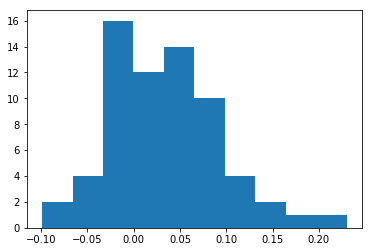

In [43]:
plt.hist(df['overall_return'])
plt.show()

## Results (NYSE, train = 84 x 50, test = 84 x 252, lookback = 84, timeout_threshold = 84)

In [25]:
results_df = pd.DataFrame(results)
results_df.columns = ['Pair', 'sharperatio', 'initialcash', 'final portfolio value']
results_df

,Pair,sharperatio,initialcash,final portfolio value
0,JBT-MAN,0.323753,1000000,1.031887e+06
1,NEWR-QTM,-0.055970,1000000,1.018235e+06
2,GHM-MAN,0.988623,1000000,1.060074e+06
3,BHE-INST,2.787306,1000000,1.093913e+06
4,FDS-VMW,-32.920545,1000000,9.966518e+05
5,CW-MCRN,-0.104804,1000000,1.016422e+06
6,FIT-SSTK,-0.377271,1000000,9.854910e+05
7,CW-TDC,-1.381346,1000000,9.865041e+05
8,AAN-INST,-0.558683,1000000,9.755008e+05
9,AAN-MSI,-2.846863,1000000,9.942752e+05


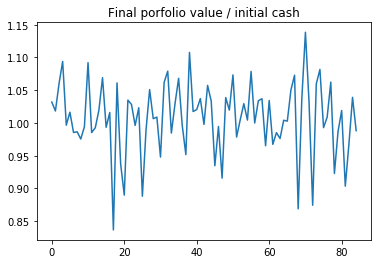

In [28]:
plt.plot(results_df['final portfolio value'] / 1000000)
plt.title('Final porfolio value / initial cash')
plt.show()

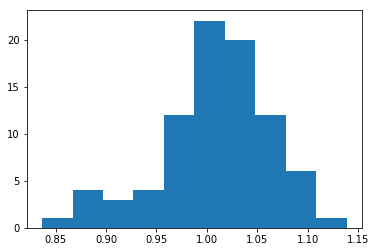

In [33]:
plt.hist(results_df['final portfolio value'] / 1000000)
plt.show()

## Results (NYSE, train = 84 x 50, test = 84 x 252, lookback = 84, cut_loss = 1.5%)

In [41]:
results_df = pd.DataFrame(results)
results_df.columns = ['Pair', 'sharperatio', 'initialcash', 'final portfolio value']
results_df

,Pair,sharperatio,initialcash,final portfolio value
0,JBT-MAN,-3.832746,1000000,9.672547e+05
1,NEWR-QTM,-0.940562,1000000,9.787552e+05
2,GHM-MAN,-11.902737,1000000,9.684221e+05
3,BHE-INST,-2.750892,1000000,9.732142e+05
4,FDS-VMW,-0.344275,1000000,1.019386e+06
5,CW-MCRN,-1.125549,1000000,9.864382e+05
6,FIT-SSTK,-0.748690,1000000,9.566826e+05
7,CW-TDC,-4.784336,1000000,9.634838e+05
8,AAN-INST,0.618497,1000000,1.071876e+06
9,AAN-MSI,0.391774,1000000,1.023467e+06


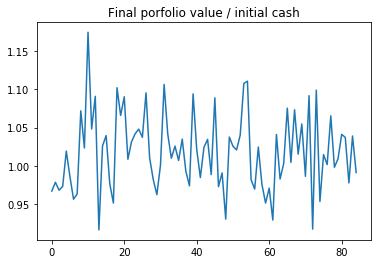

In [42]:
plt.plot(results_df['final portfolio value'] / 1000000)
plt.title('Final porfolio value / initial cash')
plt.show()

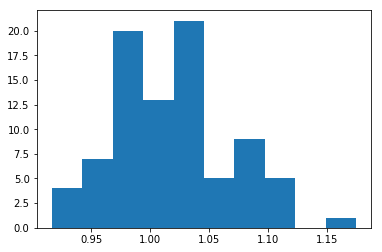

In [43]:
plt.hist(results_df['final portfolio value'] / 1000000)
plt.show()

## Results (NYSE, train = 84 x 50, test = 84 x 252, lookback = 84 x 5, cut_loss = 1.5%)

In [47]:
results_df = pd.DataFrame(results)
results_df.columns = ['Pair', 'sharperatio', 'initialcash', 'final portfolio value']
results_df

,Pair,sharperatio,initialcash,final portfolio value
0,JBT-MAN,-5.325059,1000000,9.635687e+05
1,NEWR-QTM,-0.228400,1000000,9.957639e+05
2,GHM-MAN,-16.579179,1000000,1.001193e+06
3,BHE-INST,-2.209971,1000000,9.509105e+05
4,FDS-VMW,-1.296320,1000000,1.008947e+06
5,CW-MCRN,-1.122336,1000000,9.857573e+05
6,FIT-SSTK,-1.147976,1000000,9.370491e+05
7,CW-TDC,-5.389475,1000000,9.657701e+05
8,AAN-INST,0.621613,1000000,1.086549e+06
9,AAN-MSI,2.645134,1000000,1.032169e+06


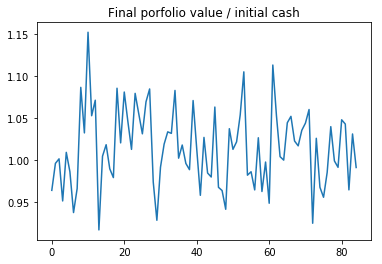

In [48]:
plt.plot(results_df['final portfolio value'] / 1000000)
plt.title('Final porfolio value / initial cash')
plt.show()

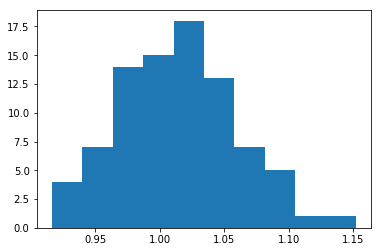

In [49]:
plt.hist(results_df['final portfolio value'] / 1000000)
plt.show()